Previsão de Churn (Abandono)

Participantes:
* Gabriel Nogueira de Moura Pereira - gnmp@cin.ufpe.br
* Mariana Guimarães Coêlho - mgc3@cin.ufpe.br

# Importando bibliotecas e dataset


In [83]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import tqdm as notebook_tqdm
import math
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

In [35]:
path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\maria\.cache\kagglehub\datasets\kapturovalexander\customers-churned-in-telecom-services\versions\3


In [36]:
df = pd.read_csv(path + '/customer_churn_telecom_services.csv')

# Funções Auxiliares

In [37]:
def plotHistogram(dataset,new = None):

    column_exclusions = []

    if new:
      column_exclusions = ["tenure", "MonthlyCharges", "TotalCharges"]

    if type(dataset) == pd.Series:
        dataset = dataset.to_frame()

    columns_to_plot = [col for col in dataset.columns if col not in column_exclusions]
    colorList = ["blue", "red", "green", "orange", "purple", "pink", "brown", "gray", "cyan", "magenta"]


    num_cols = len(columns_to_plot)
    rows = math.ceil(num_cols / 3)

    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, columnName in enumerate(columns_to_plot):
        ax = axes[i]

        if dataset[columnName].dtype == 'object' or dataset[columnName].dtype.name == 'category':
            dataset[columnName].value_counts().plot(kind='bar', color=random.choice(colorList), edgecolor='black', ax=ax)
            ax.set_title(f"Bar Plot of {columnName}")
            ax.set_xlabel(columnName)
            ax.set_ylabel("Frequency")
            ax.tick_params(axis='x', rotation=45)

        else:
            ax.hist(dataset[columnName].dropna(), bins='auto', color=random.choice(colorList), edgecolor='black')
            ax.set_title(f"Histogram of {columnName}")
            ax.set_xlabel(columnName)
            ax.set_ylabel("Frequency")

        ax.grid(axis='y', linestyle='--', alpha=0.7)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [38]:
def fix_missing_values_median(train_df, val_df, test_df, column):
    if column not in train_df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    median_value = train_df_copy[column].median()

    train_df_copy[column].fillna(median_value, inplace=True)
    val_df_copy[column].fillna(median_value, inplace=True)
    test_df_copy[column].fillna(median_value, inplace=True)

    return train_df_copy, val_df_copy, test_df_copy

In [39]:
from sklearn.impute import KNNImputer
import pandas as pd

def fix_missing_values_knn(train_df, val_df, test_df, column, n_neighbors=5):
    if column not in train_df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    numeric_cols = train_df_copy.select_dtypes(include=['number']).columns

    imputer = KNNImputer(n_neighbors=n_neighbors)

    train_df_copy[numeric_cols] = imputer.fit_transform(train_df_copy[numeric_cols])
    val_df_copy[numeric_cols] = imputer.transform(val_df_copy[numeric_cols])
    test_df_copy[numeric_cols] = imputer.transform(test_df_copy[numeric_cols])

    return train_df_copy, val_df_copy, test_df_copy

In [40]:
def plot_outliers(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_columns:
        print("Nenhuma coluna numérica encontrada no DataFrame.")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    sns.boxplot(data=df[numeric_columns], ax=ax, flierprops={
        'marker': 'o',
        'markerfacecolor': 'red',
        'markeredgecolor': 'black',
        'markersize': 8
    })

    for i, col in enumerate(numeric_columns):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        ax.text(i, upper_bound, f'{upper_bound:.2f}', ha='center', va='bottom', fontsize=10, color='blue', bbox=dict(facecolor='white', alpha=0.8))
        ax.text(i, lower_bound, f'{lower_bound:.2f}', ha='center', va='top', fontsize=10, color='blue', bbox=dict(facecolor='white', alpha=0.8))

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        for j, value in enumerate(outliers):
            ax.plot(i, value, marker='o', markersize=8, color='red', alpha=0.6)
            ax.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=9, color='darkred', bbox=dict(facecolor='white', alpha=0.8))

    ax.set_xticklabels(numeric_columns, rotation=45, ha='right', fontsize=12)
    ax.set_title("Boxplot para Identificação de Outliers", fontsize=16, pad=20)
    ax.set_ylabel("Valores", fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.plot([], [], marker='o', markersize=8, color='red', linestyle='none', label='Outliers')
    ax.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()

In [41]:
def remove_outliers(train_df, val_df, test_df, column):
    if column not in train_df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    train_df_filtered = train_df[(train_df[column] >= lower_bound) & (train_df[column] <= upper_bound)]
    val_df_filtered = val_df[(val_df[column] >= lower_bound) & (val_df[column] <= upper_bound)]
    test_df_filtered = test_df[(test_df[column] >= lower_bound) & (test_df[column] <= upper_bound)]

    return train_df_filtered, val_df_filtered, test_df_filtered

In [42]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['number']).columns.tolist()

In [43]:
def preprocess_categorical_data(train_df, val_df, test_df,
                                binary_cols=["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"],
                                nominal_cols=["gender", "PaymentMethod", "MultipleLines", "InternetService", "TechSupport",
                                              "StreamingTV", "StreamingMovies", "OnlineBackup", "OnlineSecurity", "DeviceProtection"],
                                ordinal_cols=["Contract","tenure"]):

    train_df_copy, val_df_copy, test_df_copy = train_df.copy(), val_df.copy(), test_df.copy()

    for col in binary_cols:
        mapping = {'Yes': 1, 'No': 0}
        train_df_copy[col] = train_df[col].map(mapping).astype(int)
        val_df_copy[col] = val_df[col].map(mapping).astype(int)
        test_df_copy[col] = test_df[col].map(mapping).astype(int)

    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    onehot_encoder.fit(train_df_copy[nominal_cols])

    train_onehot = onehot_encoder.transform(train_df_copy[nominal_cols])
    val_onehot = onehot_encoder.transform(val_df_copy[nominal_cols])
    test_onehot = onehot_encoder.transform(test_df_copy[nominal_cols])

    onehot_cols = onehot_encoder.get_feature_names_out(nominal_cols)

    train_onehot_df = pd.DataFrame(train_onehot, columns=onehot_cols, index=train_df.index)
    val_onehot_df = pd.DataFrame(val_onehot, columns=onehot_cols, index=val_df.index)
    test_onehot_df = pd.DataFrame(test_onehot, columns=onehot_cols, index=test_df.index)

    train_df_copy = train_df_copy.drop(columns=nominal_cols).join(train_onehot_df)
    val_df_copy = val_df_copy.drop(columns=nominal_cols).join(val_onehot_df)
    test_df_copy = test_df_copy.drop(columns=nominal_cols).join(test_onehot_df)

    ordinal_encoder = OrdinalEncoder()
    ordinal_encoder.fit(train_df_copy[ordinal_cols])

    train_df_copy[ordinal_cols] = ordinal_encoder.transform(train_df_copy[ordinal_cols])
    val_df_copy[ordinal_cols] = ordinal_encoder.transform(val_df_copy[ordinal_cols])
    test_df_copy[ordinal_cols] = ordinal_encoder.transform(test_df_copy[ordinal_cols])

    return train_df_copy, val_df_copy, test_df_copy

In [44]:
def bin_columns(df_train, df_val, df_test, column):
    if column not in df_train.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    # Definindo os limites dos bins para garantir que 0 e 72 sejam incluídos
    bins = [-0.1, 18, 36, 54, 72]
    labels = ["0-18", "19-36", "37-54", "55-72"]

    df_train_copy = df_train.copy()
    df_val_copy = df_val.copy()
    df_test_copy = df_test.copy()

    df_train_copy[column] = pd.cut(df_train_copy[column], bins=bins, labels=labels, right=True, include_lowest=True)
    df_val_copy[column] = pd.cut(df_val_copy[column], bins=bins, labels=labels, right=True, include_lowest=True)
    df_test_copy[column] = pd.cut(df_test_copy[column], bins=bins, labels=labels, right=True, include_lowest=True)

    return df_train_copy, df_val_copy, df_test_copy


In [45]:
def bin_and_encode(df_train, df_val, df_test):
    numerical_cols = ["tenure"]
    bins = [0, 18, 36, 54, 72]
    labels = ["0-18", "19-36", "37-54", "55-72"]

    df_train_copy = df_train.copy()
    df_val_copy = df_val.copy()
    df_test_copy = df_test.copy()

    df_train_copy["tenure"] = pd.cut(df_train_copy["tenure"], bins=bins, labels=labels,right=True)
    df_val_copy["tenure"] = pd.cut(df_val_copy["tenure"], bins=bins, labels=labels,right=True)
    df_test_copy["tenure"] = pd.cut(df_test_copy["tenure"], bins=bins, labels=labels,right=True)

    ordinal_encoder = OrdinalEncoder()
    df_train_copy[numerical_cols] = ordinal_encoder.fit_transform(df_train_copy[numerical_cols])

    df_val_copy[numerical_cols] = ordinal_encoder.transform(df_val_copy[numerical_cols])
    df_test_copy[numerical_cols] = ordinal_encoder.transform(df_test_copy[numerical_cols])

    return df_train_copy, df_val_copy, df_test_copy

In [46]:
def normalize_data(train_df, val_df, test_df):
    scaler = MinMaxScaler()
    numeric_cols = train_df.select_dtypes(include=['number']).columns

    scaler.fit(train_df[numeric_cols])

    train_df[numeric_cols] = scaler.transform(train_df[numeric_cols])
    val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

    return train_df, val_df, test_df

# 1. Eliminar variáveis identificadoras se existirem (chaves de identificação,cpf,rg,nome da pessoa).

In [47]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [48]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Não possui variáveis identificadoras nesse dataset.



In [49]:
df["tenure"].max()

72

# 2. Dividir a base de dados em 3 subsets (k=3 folds).

In [50]:
from sklearn.model_selection import KFold, train_test_split

kf = KFold(n_splits=3, shuffle=True)

for i, (train_val_index, test_index) in enumerate(kf.split(df)):
    dfTest = df.iloc[test_index]

    dfTrain, dfVal = train_test_split(df.iloc[train_val_index], test_size=0.2, random_state=12)

    if i == 0:
        dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = dfTrain, dfVal, dfTest
    elif i == 1:
        dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = dfTrain, dfVal, dfTest
    else:
        dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = dfTrain, dfVal, dfTest

# 3.Análise Explorátoria de Dados

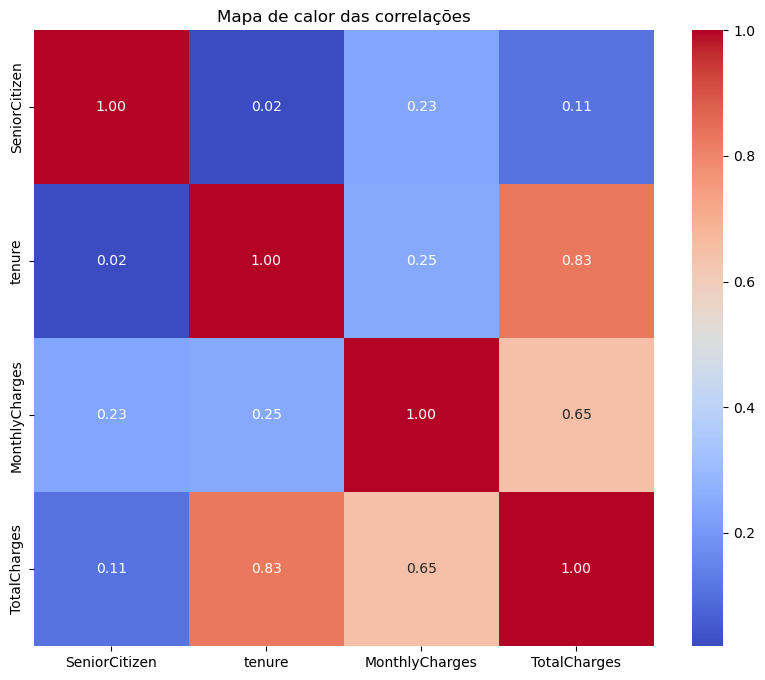

In [51]:
numericdfTrainFoldOne = dfTrainFoldOne.select_dtypes(include=["number"])

correlation_matrix = numericdfTrainFoldOne.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor das correlações")
plt.show()

In [52]:
dfTrainFoldOne.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6641,Female,0,No,No,16,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,50.15,762.25,Yes
6103,Male,0,No,No,16,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),19.75,294.90,No
4889,Male,0,Yes,Yes,47,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),113.45,5317.80,No
2752,Male,0,Yes,Yes,31,No,No phone service,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Bank transfer (automatic),35.40,1077.50,Yes
4263,Female,0,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),115.55,8312.40,No


<Axes: xlabel='Churn', ylabel='count'>

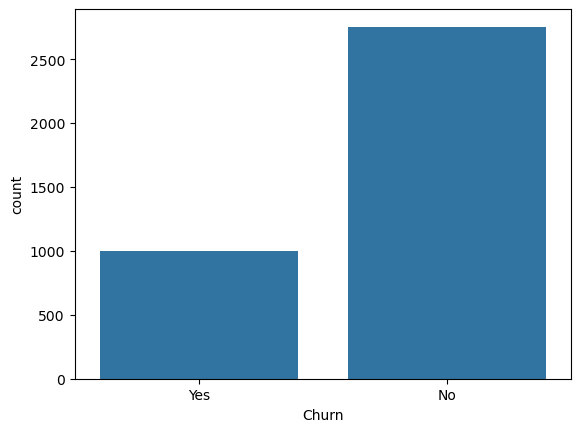

In [53]:
sns.countplot(x='Churn', data=dfTrainFoldOne)

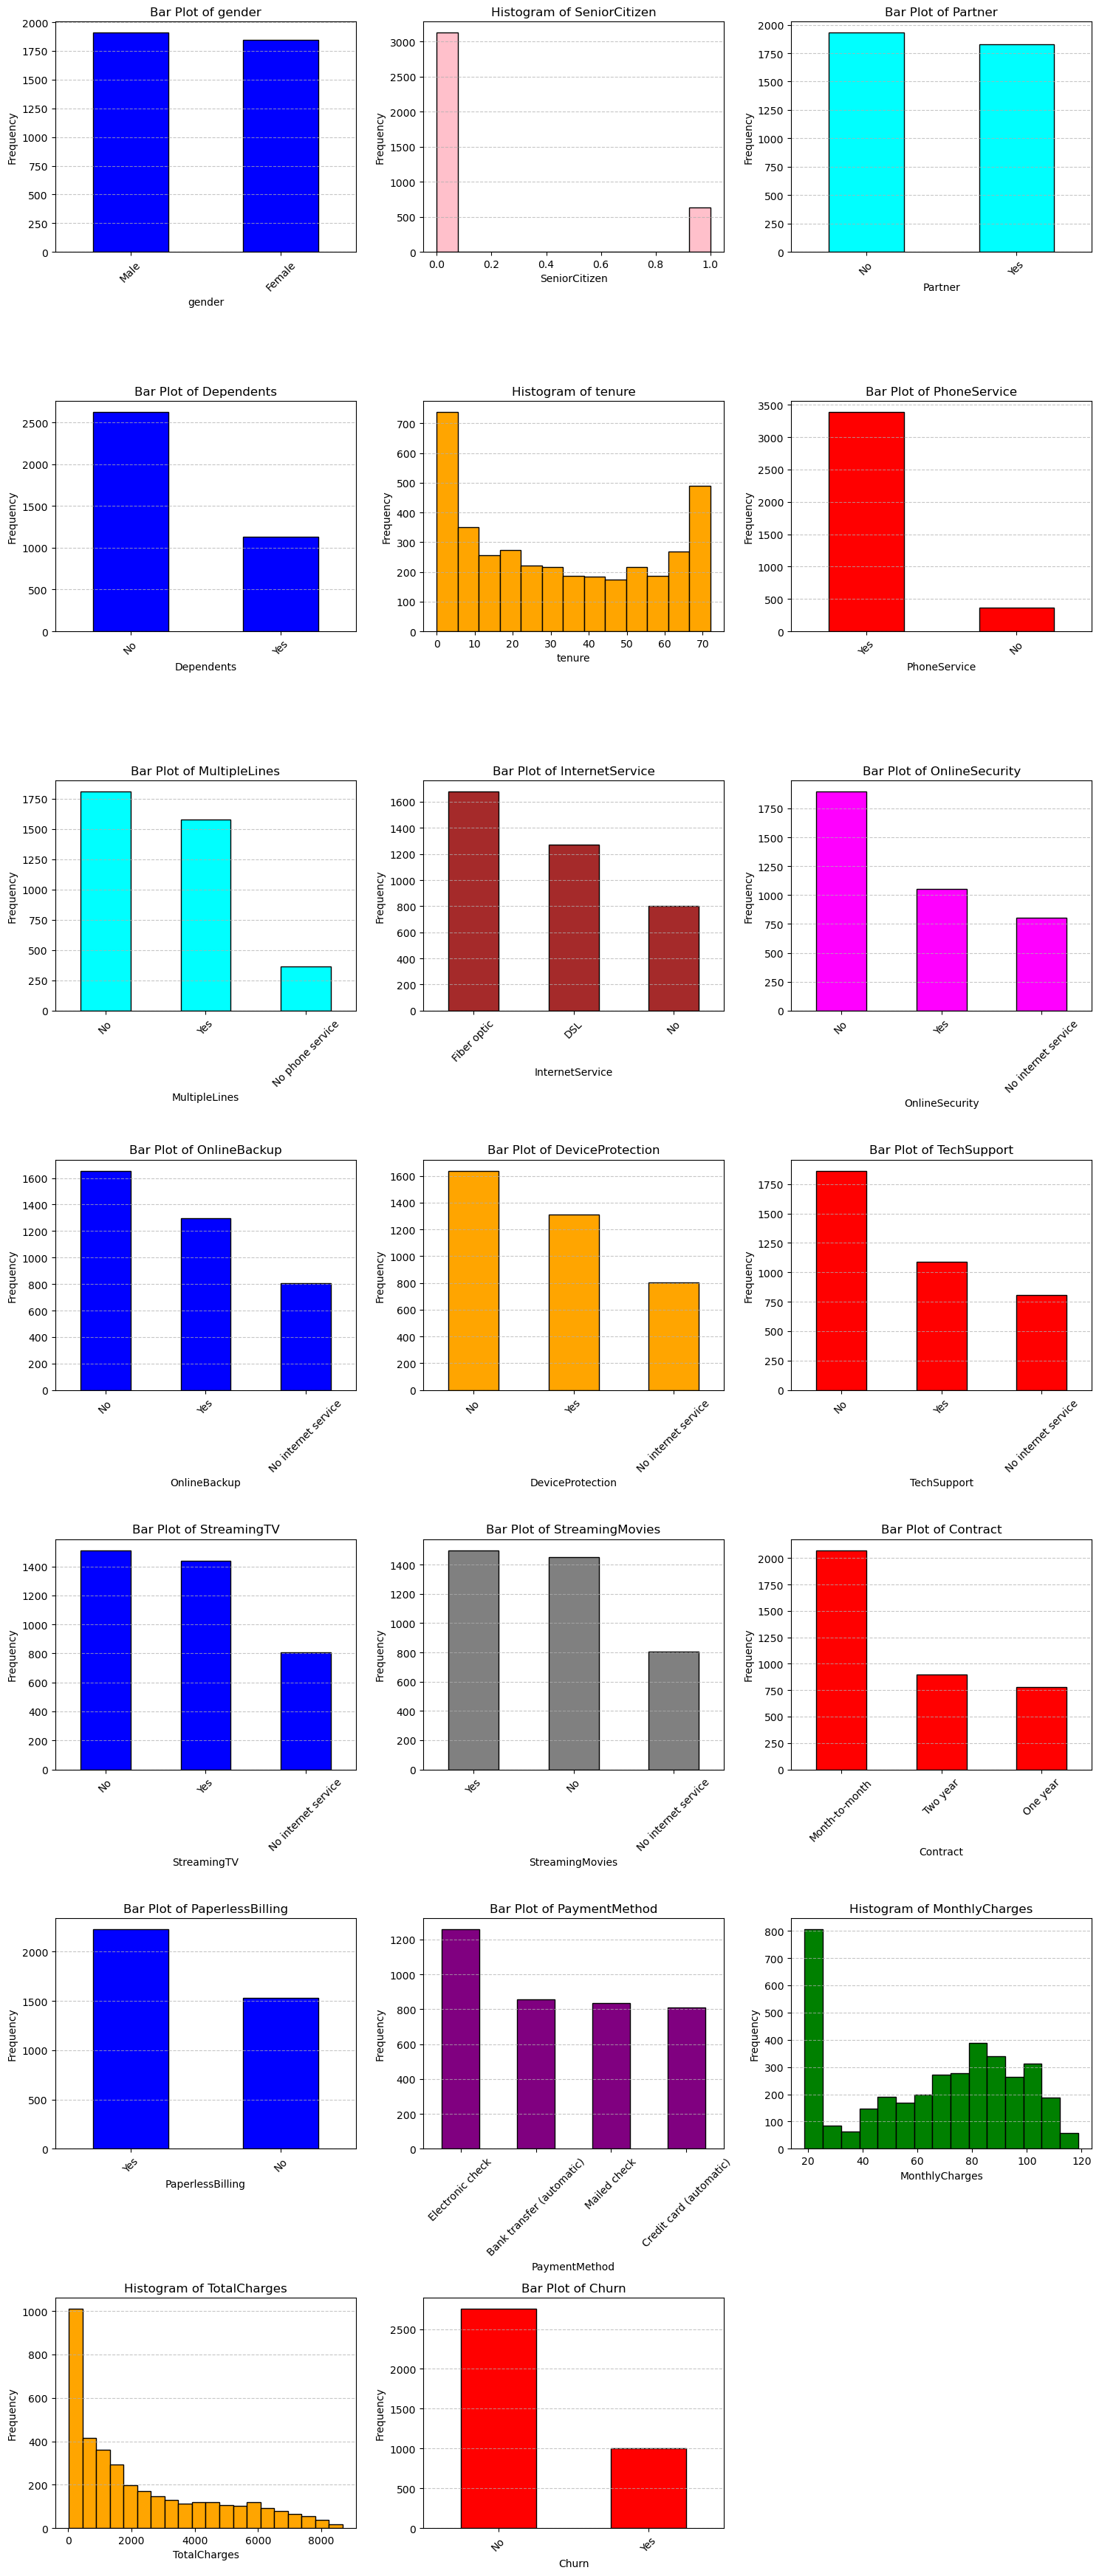

In [54]:
plotHistogram(dfTrainFoldOne)

Como podemos observar, as variáveis númericas 'tenure', 'MonthlyCharges' e 'TotallyCharges' possuem um grande variação de valores e, por isso trazem a necessidade colocar em faixas, como mostrado abaixo:

In [55]:
maxTenure, maxMonthlyCharges, maxTotallyCharges = dfTrainFoldOne['tenure'].max(), dfTrainFoldOne['MonthlyCharges'].max(), dfTrainFoldOne['TotalCharges'].max()
print(maxTenure)
print(maxMonthlyCharges)
print(maxTotallyCharges)


72
118.75
8672.45


# 4. Tratamento dos Dados

## 4.1 Tratamento de Dados Nulos

In [56]:
dfTrainFoldOne.isnull().sum() / len(dfTrainFoldOne) * 100

gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.212993
Churn               0.000000
dtype: float64

### *Median Imputation*

Como aproximadamente `16%` da coluna `TotalCharges` não possui valores, optamos por utilizar a *median imputation* para preencher os valores.

In [57]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = fix_missing_values_median(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy(), "TotalCharges")

In [58]:
dfTrainFoldOne.isnull().sum() / len(dfTrainFoldOne) * 100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [59]:
dfTestFoldOne.isnull().sum() / len(dfTestFoldOne) * 100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [60]:
dfValFoldOne.isnull().sum() / len(dfValFoldOne) * 100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

## 4.2 Tratamento de Outliers

C:\Users\maria\AppData\Local\Temp\ipykernel_11124\2271309273.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(numeric_columns, rotation=45, ha='right', fontsize=12)


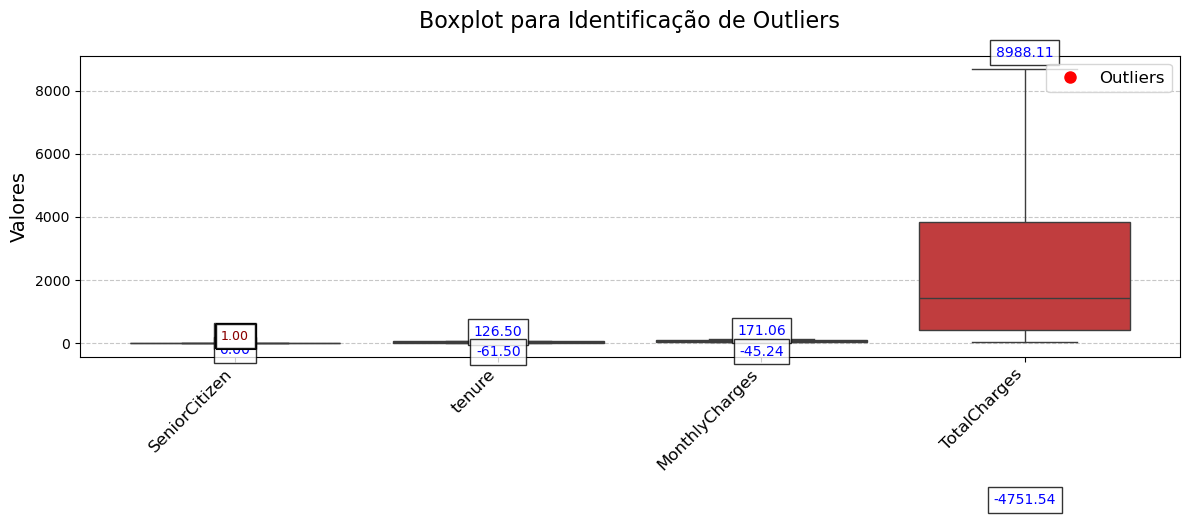

In [61]:
plot_outliers(dfTrainFoldOne)

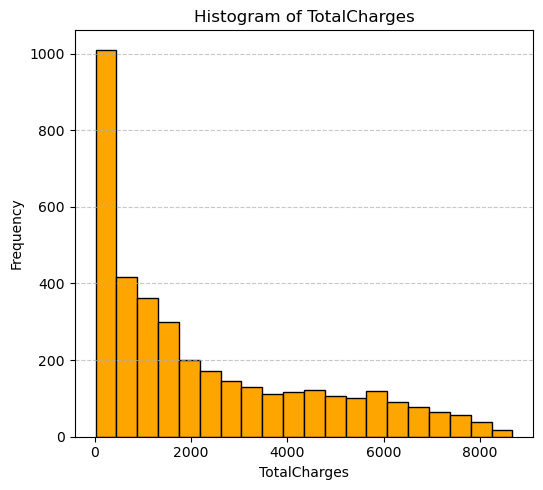

In [62]:
plotHistogram(dfTrainFoldOne['TotalCharges'])

In [63]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = remove_outliers(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy(), "TotalCharges")

In [64]:
dfTrainFoldOne["tenure"].isnull().sum()

0

In [65]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = bin_columns(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy(), "tenure")

In [66]:
dfTrainFoldOne["tenure"].isnull().sum()

0

## 4.3 Normalização de dados numéricos com Min-Max

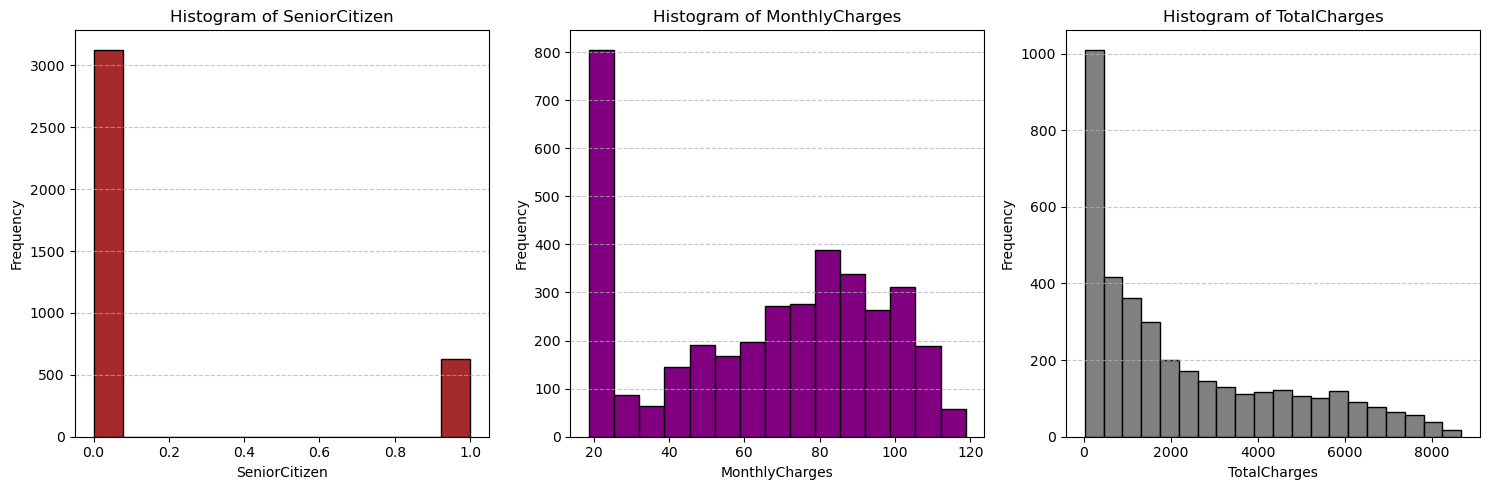

In [67]:
numeric_cols = dfTrainFoldOne.select_dtypes(include=['number'])
plotHistogram(numeric_cols)

In [68]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = normalize_data(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy())

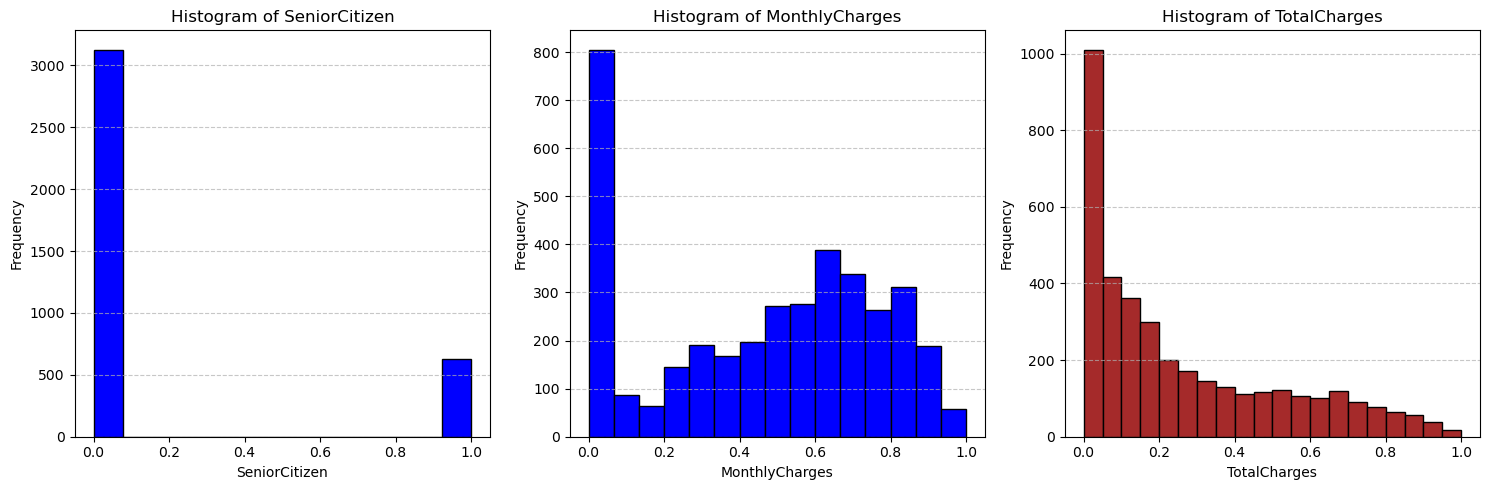

In [69]:
plotHistogram(dfTrainFoldOne[numeric_cols.columns])

## 4.4 Tratamento de Variáveis Categóricas

A seguir, transformamos as variáveis categóricas em numéricas. Para as colunas binárias, mapeamos os valores "Yes" e "No" para 1 e 0, respectivamente. Em seguida, aplicamos **One-Hot Encoding** a todas as variáveis categóricas(não necessário utilizar a codificação de bits, pois o máximo de valores únicos em uma categoria é 4), **exceto "Contract"**, pois ela possui um aspecto ordinal e deve ser codificada de forma diferente.  

Além disso, a variável numérica **"tenure"** é convertida em faixas, representando diferentes períodos de tempo, e depois transformada em valores numéricos ordinais.  

Essas transformações são realizadas nas funções **`preprocess_categorical_data`** (para variáveis categóricas) e **`bin_and_encode`** (para a variável "tenure").

In [70]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = preprocess_categorical_data(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy())

In [71]:
dfTrainFoldOne.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes
6641,0.0,0,0,0.0,1,0.0,1,0.313657,0.085912,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6103,0.0,0,0,0.0,1,0.0,0,0.009505,0.031906,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4889,0.0,1,1,2.0,1,1.0,1,0.946973,0.612343,0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2752,0.0,1,1,1.0,0,0.0,0,0.166083,0.122341,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4263,0.0,1,0,3.0,1,2.0,1,0.967984,0.958393,0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


## 4.4 Tratamentos nos *folds* `k=2` e `k=3`

### `k=2`

In [72]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = fix_missing_values_median(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy(), "TotalCharges")

In [73]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = remove_outliers(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy(), "TotalCharges")

In [74]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = normalize_data(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy())

In [75]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = preprocess_categorical_data(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy())
#dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = bin_and_encode(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy())

### `k=3`

In [76]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = fix_missing_values_median(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy(), "TotalCharges")

In [77]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = remove_outliers(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy(), "TotalCharges")

In [78]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = normalize_data(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy())

In [79]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = preprocess_categorical_data(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy())
#dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = bin_and_encode(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy())

# 5. Experimentos

## *Random Forest*

- Número de árvores (`n_estimators`)
- Profundidade máxima (`max_depth`)
- Número mínimo de amostras para dividir um nó (`min_samples_split`)
- Critério de divisão (`criterion`)

### Parâmetros que serão variados

In [80]:
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]

In [94]:
def objective_RF(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    # testar com o roc-auc
    score = cross_val_score(model, X_train_fold_one, y_train_fold_one, cv=3, scoring="f1").mean()
    return score

In [95]:
study_RF = optuna.create_study(direction="maximize")  # Maximizar acurácia
study_RF.optimize(objective_RF, n_trials=50)  # Testar 50 combinações de hiperparâmetros

[I 2025-03-21 14:57:08,510] A new study created in memory with name: no-name-7dd7c15e-48ec-4590-a51e-48c5af3531b7
[I 2025-03-21 14:57:11,625] Trial 0 finished with value: 0.5752459757924174 and parameters: {'n_estimators': 240, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5752459757924174.
[I 2025-03-21 14:57:13,784] Trial 1 finished with value: 0.5601063008959261 and parameters: {'n_estimators': 170, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.5752459757924174.
[I 2025-03-21 14:57:15,027] Trial 2 finished with value: 0.5728832273191361 and parameters: {'n_estimators': 96, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.5752459757924174.
[I 2025-03-21 14:57:15,963] Trial 3 finished with value: 0.5022214452623343 and parameters: {'n_estimators': 74, 'max_depth': 3, 'min_samples

In [96]:
print("Melhores hiperparâmetros:", study_RF.best_params)

Melhores hiperparâmetros: {'n_estimators': 168, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'entropy'}


### Treinamento do Modelo

In [99]:
best_params_RF = study_RF.best_params
final_model = RandomForestClassifier(**best_params_RF, random_state=42, n_jobs=-1)
final_model.fit(X_train_fold_one, y_train_fold_one)

y_pred = final_model.predict(X_test_fold_one)
accuracy_RF = accuracy_score(y_test_fold_one, y_pred)
f1_value_RF = f1_score(y_test_fold_one, y_pred)

print("Acurácia final: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final: {:.2f}%".format(f1_value_RF * 100))

Acurácia final: 79.60%
F1-Score final: 57.87%


## MLP

### Parâmetros que serão variados

- Número de camadas
- Número de neurônios
- Taxa de aprendizagem
- Otimização

In [112]:
print("CUDA disponível:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("Versão do PyTorch:", torch.__version__)

CUDA disponível: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Versão do PyTorch: 2.6.0+cu118


In [103]:
def objective_MLP(trial):
    hidden_layer_sizes = (
        trial.suggest_int("n_neurons", 10, 200),
    )
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)

    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        learning_rate_init=learning_rate_init,
        solver="adam",
        max_iter=500,
        random_state=42
    )
    scores = cross_val_score(model, X_train_fold_one, y_train_fold_one, cv=3, scoring="f1")
    model.fit(X_train_fold_one, y_train_fold_one)
    y_pred = model.predict(X_test_fold_one)
    return scores.mean()
def objective_MLP_Cuda(trial):
    n_neurons = trial.suggest_int("n_neurons", 10, 200)
    activation_name = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    learning_rate = trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)

    input_size = X_train_fold_one.shape[1]
    output_size = len(np.unique(y_train_fold_one))

    layers = [nn.Linear(input_size, n_neurons)]
    if activation_name == "relu":
        layers.append(nn.ReLU())
    elif activation_name == "tanh":
        layers.append(nn.Tanh())
    elif activation_name == "logistic":
        layers.append(nn.Sigmoid())
    layers.append(nn.Linear(n_neurons, output_size))

    model = nn.Sequential(*layers).to(device)

    X_train_tensor = torch.tensor(X_train_fold_one.to_numpy(), dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold_one.to_numpy(), dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_fold_one.to_numpy(), dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_fold_one.to_numpy(), dtype=torch.long)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, y_pred = torch.max(outputs, 1)

    f1 = f1_score(y_test_tensor.cpu(), y_pred.cpu(), average="macro")
    return f1

In [110]:
study_MLP = optuna.create_study(direction="maximize")
study_MLP.optimize(objective_MLP_Cuda, n_trials=50)

print("Melhores hiperparâmetros:", study_MLP.best_params)

[I 2025-03-21 15:10:30,302] A new study created in memory with name: no-name-55b70a3d-7647-4807-a88c-0b3c596a476b
[I 2025-03-21 15:10:30,750] Trial 0 finished with value: 0.422244094488189 and parameters: {'n_neurons': 189, 'activation': 'logistic', 'learning_rate_init': 8.031353305029526e-05}. Best is trial 0 with value: 0.422244094488189.
[I 2025-03-21 15:10:30,980] Trial 1 finished with value: 0.5452053161690208 and parameters: {'n_neurons': 192, 'activation': 'tanh', 'learning_rate_init': 8.917169446440393e-05}. Best is trial 1 with value: 0.5452053161690208.
[I 2025-03-21 15:10:31,222] Trial 2 finished with value: 0.4172958709085358 and parameters: {'n_neurons': 94, 'activation': 'tanh', 'learning_rate_init': 3.791149166034396e-05}. Best is trial 1 with value: 0.5452053161690208.
[I 2025-03-21 15:10:31,463] Trial 3 finished with value: 0.6168508389316124 and parameters: {'n_neurons': 153, 'activation': 'relu', 'learning_rate_init': 1.6653731167442694e-05}. Best is trial 3 with val

Melhores hiperparâmetros: {'n_neurons': 181, 'activation': 'tanh', 'learning_rate_init': 0.005942347961274125}


In [111]:
# Converte os dados para tensor
X_train_tensor = torch.tensor(X_train_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_one.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_one.to_numpy(), dtype=torch.long)

best_params_MLP = study_MLP.best_params
n_neurons = best_params_MLP["n_neurons"]
activation_name = best_params_MLP["activation"]
learning_rate = best_params_MLP["learning_rate_init"]

input_size = X_train_fold_one.shape[1]
output_size = len(torch.unique(y_train_tensor))

layers = [nn.Linear(input_size, n_neurons)]
if activation_name == "relu":
    layers.append(nn.ReLU())
elif activation_name == "tanh":
    layers.append(nn.Tanh())
elif activation_name == "logistic":
    layers.append(nn.Sigmoid())
layers.append(nn.Linear(n_neurons, output_size))

model = nn.Sequential(*layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(100):  # Pode ajustar epochs
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred = torch.max(outputs, 1)

y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test_tensor.cpu().numpy()

acc = accuracy_score(y_test_cpu, y_pred_cpu)
f1 = f1_score(y_test_cpu, y_pred_cpu, average="macro")

print("Acurácia final: {:.2f}%".format(acc * 100))
print("F1-Score final: {:.2f}%".format(f1 * 100))

Acurácia final: 80.37%
F1-Score final: 73.56%


## KAN

### Parâmetros que serão variados

## *Transformer*

### Parâmetros que serão variados

## KAN *Transformer*

### Parâmetros que serão variados

## *Gradient Boosting*

### Parâmetros que serão variados